#Royal Cybers: End-to-End Machine Learning Pipeline for Personalized recommendations in Databricks 

## Load Dataset

In [0]:
# Load Dataset from S3 Bucket
cosmetic_store_data_path = "s3://e-commerce-pipeline-dataset/Cosmetic Store Website Data.csv"
reviews_data_path = "s3://e-commerce-pipeline-dataset/nyka_top_brands_cosmetics_product_reviews.csv"
product_mapping_path = "s3://e-commerce-pipeline-dataset/unique_product_id_pairings.csv"

cosmetic_df = spark.read.csv(cosmetic_store_data_path, header=True, inferSchema=True)
reviews_df = spark.read.csv(reviews_data_path, header=True, inferSchema=True)
mapping_df = spark.read.csv(product_mapping_path, header=True, inferSchema=True)

In [0]:
cosmetic_df.show(5)

+-------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|   brand|price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+--------+-----+---------+--------------------+
|2020-01-01 00:00:00|      view|   5809910|1602943681873052386|         NULL| grattol| 5.24|595414620|4adb70bb-edbd-498...|
|2020-01-01 00:00:09|      view|   5812943|1487580012121948301|         NULL|kinetics| 3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:19|      view|   5798924|1783999068867920626|         NULL|  zinger| 3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:24|      view|   5793052|1487580005754995573|         NULL|    NULL| 4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:25|      view|   5899926|2115334439910245200|         NULL|    NULL| 3.92|484071203|cff70ddf-529e-4b0...|
+-------

In [0]:
reviews_df.show(5)

+----------+----------+---------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------+--------------+--------------------+----+-----+--------------+--------------------+------------+--------------------+
|product_id|brand_name|review_id|        review_title|         review_text|        author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title| mrp|price|product_rating|product_rating_count|product_tags|         product_url|
+----------+----------+---------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------+--------------+--------------------+----+-----+--------------+--------------------+------------+--------------------+
|    781070|      Olay| 16752142|Worth buying 50g one|Works as it claim...| Ashton Dsouza|2021-01-23 15:17:18|          5.0|      True|   False|Verified Buyer|Olay Ultra Lightw...|1999| 1599|           4.1|        

In [0]:
mapping_df.show(5)

+-----------------+------------------+
|product_id_events|product_id_reviews|
+-----------------+------------------+
|            11719|            209281|
|            15161|           2645330|
|            16686|           3445855|
|            27658|           4749403|
|            34768|            995305|
+-----------------+------------------+
only showing top 5 rows



%md
## Initial Data Cleaning

In [0]:
# Drop Duplicates
cosmetic_df = cosmetic_df.dropDuplicates()
reviews_df = reviews_df.dropDuplicates()
mapping_df = mapping_df.dropDuplicates()

In [0]:
# Standardizing column names
cosmetic_df = cosmetic_df.withColumnRenamed("product_id", "cosmeticProductId") \
                         .withColumnRenamed("price", "cosmetic_price") 

reviews_df = reviews_df.withColumnRenamed("product_id", "reviewProductId") \
                       .withColumnRenamed("price", "review_price")

mapping_df = mapping_df.withColumnRenamed("product_id_events", "cosmeticProductId") \
                       .withColumnRenamed("product_id_reviews", "reviewProductId")

In [0]:
# Drop unnecessary columns and fill missing values
cosmetic_df = cosmetic_df.filter(cosmetic_df['cosmetic_price'] > 0)

mapping_df = mapping_df.na.drop()

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

def clean_text(text):
    if text:
        text = text.lower()
        text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
        text = re.sub(r'[^a-zA-Z0-9\s/.]', '', text)  
        return text.strip()
    return text  

# Register UDF
clean_text_udf = udf(clean_text, StringType())

reviews_df = reviews_df.drop("product_tags")
reviews_df = reviews_df.fillna({
    'review_text': 'No review', 
    'brand_name': 'Unknown', 
    'review_label': 'No Label',
    'product_title': 'Unknown Title'
})

# Clean review_title and review_text
reviews_df = reviews_df.withColumn("review_title_clean", clean_text_udf(reviews_df["review_title"]))
reviews_df = reviews_df.withColumn("review_text_clean", clean_text_udf(reviews_df["review_text"]))

reviews_df.select("review_title", "review_title_clean", "review_text", "review_text_clean").show(5)

+------------------+------------------+--------------------+--------------------+
|      review_title|review_title_clean|         review_text|   review_text_clean|
+------------------+------------------+--------------------+--------------------+
|Invisible & Smooth| invisible  smooth|Wore these when I...|wore these when i...|
|              Nice|              nice|Works as it claim...|works as it claim...|
|             Great|             great|It Won't let your...|it wont let your ...|
|          Easy fix|          easy fix|This is one easy ...|this is one easy ...|
|        Give a try|        give a try|This is my first ...|this is my first ...|
+------------------+------------------+--------------------+--------------------+
only showing top 5 rows



In [0]:
# Filtering our multi classificaiton 
valid_events = ["view", "cart", "remove_from_cart", "purchase"]
cosmetic_df = cosmetic_df.filter(cosmetic_df.event_type.isin(valid_events))

cosmetic_df.groupBy("event_type").count().show()

+----------------+-------+
|      event_type|  count|
+----------------+-------+
|        purchase| 263570|
|            view|2032076|
|            cart|1126995|
|remove_from_cart| 609461|
+----------------+-------+



In [0]:
cosmetic_df.show(5)

+-------------------+----------+-----------------+-------------------+-------------+--------+--------------+---------+--------------------+
|         event_time|event_type|cosmeticProductId|        category_id|category_code|   brand|cosmetic_price|  user_id|        user_session|
+-------------------+----------+-----------------+-------------------+-------------+--------+--------------+---------+--------------------+
|2020-01-01 00:00:19|      view|          5798924|1783999068867920626|         NULL|  zinger|          3.97|595412617|46a5010f-bd69-4fb...|
|2020-01-01 00:00:25|      view|          5899926|2115334439910245200|         NULL|    NULL|          3.92|484071203|cff70ddf-529e-4b0...|
|2020-01-01 00:00:24|      view|          5793052|1487580005754995573|         NULL|    NULL|          4.92|420652863|546f6af3-a517-475...|
|2020-01-01 00:00:09|      view|          5812943|1487580012121948301|         NULL|kinetics|          3.97|595414640|c8c5205d-be43-4f1...|
|2020-01-01 00:00:00

In [0]:
reviews_df.show(5)

+---------------+--------------+---------+------------------+--------------------+-----------------+-------------------+-------------+----------+--------+--------------+--------------------+---+------------+--------------+--------------------+--------------------+------------------+--------------------+
|reviewProductId|    brand_name|review_id|      review_title|         review_text|           author|        review_date|review_rating|is_a_buyer|pro_user|  review_label|       product_title|mrp|review_price|product_rating|product_rating_count|         product_url|review_title_clean|   review_text_clean|
+---------------+--------------+---------+------------------+--------------------+-----------------+-------------------+-------------+----------+--------+--------------+--------------------+---+------------+--------------+--------------------+--------------------+------------------+--------------------+
|         785729|Nykaa Naturals| 27389259|Invisible & Smooth|Wore these when I...|   

In [0]:
mapping_df.show(5)

+-----------------+---------------+
|cosmeticProductId|reviewProductId|
+-----------------+---------------+
|            34768|         995305|
|            15161|        2645330|
|            16686|        3445855|
|            19162|        3494214|
|            11719|         209281|
+-----------------+---------------+
only showing top 5 rows



## Manage Delta Tables

In [0]:
cosmetic_delta_path = "/mnt/delta/cosmetic_store_data"
reviews_delta_path = "/mnt/delta/product_reviews"
mapping_delta_path = "/mnt/delta/product_mapping"

In [0]:
# Convert each cleaned DataFrame to Delta format
cosmetic_df.write.format("delta").mode("overwrite").save(cosmetic_delta_path)
reviews_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(reviews_delta_path)
mapping_df.write.format("delta").mode("overwrite").save(mapping_delta_path)


In [0]:
# Load Delta tables directly from paths
cosmetic_df = spark.read.format("delta").load(cosmetic_delta_path)
reviews_df = spark.read.format("delta").load(reviews_delta_path)
mapping_df = spark.read.format("delta").load(mapping_delta_path)


## Data Transformation

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import mean, stddev, col
from pyspark.sql.types import DoubleType, IntegerType

### Transform Cosmetic Data (Structured Interaction Data)

In [0]:
# Encode `event_type` column for interactions (structured data)
indexer = StringIndexer(inputCol="event_type", outputCol="event_type_index")
cosmetic_df = indexer.fit(cosmetic_df).transform(cosmetic_df)

# Scale `cosmetic_price` column
assembler = VectorAssembler(inputCols=["cosmetic_price"], outputCol="price_vec")
cosmetic_df = assembler.transform(cosmetic_df)

scaler = StandardScaler(inputCol="price_vec", outputCol="price_scaled")
cosmetic_df = scaler.fit(cosmetic_df).transform(cosmetic_df)

### Transform Reviews Data with Bert Tokenizer (Unstructured Sentiment Data)

In [0]:
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Load a pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

2024-11-20 02:37:14.463128: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 02:37:14.466825: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 02:37:14.522627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 02:37:15.797807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load tokenizer and model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("dipawidia/xlnet-base-cased-product-review-sentiment-analysis")
model = AutoModelForSequenceClassification.from_pretrained("dipawidia/xlnet-base-cased-product-review-sentiment-analysis")

# Define a function for sentiment prediction
def get_sentiment(review):
    if not review:
        return "Neutral"  # Default sentiment for empty reviews
    # Tokenize the input text
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Get model outputs
    outputs = model(**inputs)
    logits = outputs.logits
    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    # Get the predicted label
    predicted_class = torch.argmax(probabilities, dim=1).item()
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return sentiment_map[predicted_class]

# Register the function as a UDF
get_sentiment_udf = udf(get_sentiment, StringType())

# Apply the UDF to the DataFrame
reviews_df = reviews_df.withColumn("sentiment", get_sentiment_udf(reviews_df["review_text_clean"]))

# Display results
reviews_df.select("review_text_clean", "sentiment").show(5)

+--------------------+---------+
|   review_text_clean|sentiment|
+--------------------+---------+
|wore these when i...| Negative|
|works as it claim...| Negative|
|it wont let your ...| Negative|
|this is one easy ...|  Neutral|
|this is my first ...|  Neutral|
+--------------------+---------+
only showing top 5 rows



In [0]:
# Cast numerical columns to appropriate types
reviews_df = reviews_df.withColumn("mrp", reviews_df["mrp"].cast(DoubleType())) \
    .withColumn("review_price", reviews_df["review_price"].cast(DoubleType())) \
    .withColumn("product_rating", reviews_df["product_rating"].cast(DoubleType())) \
    .withColumn("product_rating_count", reviews_df["product_rating_count"].cast(IntegerType()))

### Transform Mapping Data

In [0]:
# Cast columns to IntegerType in `mapping_df`
mapping_df = mapping_df.withColumn("cosmeticProductId", mapping_df["cosmeticProductId"].cast(IntegerType()))
mapping_df = mapping_df.withColumn("reviewProductId", mapping_df["reviewProductId"].cast(IntegerType()))

# Calculate mean and standard deviation for filtering outliers
stats = mapping_df.select(
    mean("reviewProductId").alias("mean_reviews"),
    stddev("reviewProductId").alias("stddev_reviews")
).collect()[0]

mean_reviews = stats["mean_reviews"]
stddev_reviews = stats["stddev_reviews"]

# Filter out outliers beyond 3 standard deviations
mapping_df = mapping_df.filter(
    (col("reviewProductId") > mean_reviews - 3 * stddev_reviews) &
    (col("reviewProductId") < mean_reviews + 3 * stddev_reviews)
)

# Scale `cosmeticProductId` and `reviewProductId` in `mapping_df`
assembler = VectorAssembler(inputCols=["cosmeticProductId", "reviewProductId"], outputCol="mapping_features_vec")
mapping_df = assembler.transform(mapping_df)

scaler = StandardScaler(inputCol="mapping_features_vec", outputCol="mapping_scaled_features")
mapping_df = scaler.fit(mapping_df).transform(mapping_df)

## Combine the Transformed Data

In [0]:
# Join `cosmetic_df` and `mapping_df` on `cosmeticProductId`
cosmetic_mapped_df = cosmetic_df.join(mapping_df, cosmetic_df["cosmeticProductId"] == mapping_df["cosmeticProductId"], "inner")

# Join the result with `reviews_df` on `reviewProductId`
combined_df = cosmetic_mapped_df.join(reviews_df, cosmetic_mapped_df["reviewProductId"] == reviews_df["reviewProductId"], "inner")

# Drop the duplicate one
combined_df = combined_df.drop("cosmeticProductId", "reviewProductId", "event_type", "brand_name", "sentiment")

In [0]:
# Save combined_df to Delta table
combined_data_path = "/mnt/delta/combined_cleaned_data"
combined_df.write.format("delta").mode("overwrite").option("overwriteSchema", "true").save(combined_data_path)

In [0]:
combined_df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- cosmetic_price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)
 |-- event_type_index: double (nullable = false)
 |-- price_vec: vector (nullable = true)
 |-- price_scaled: vector (nullable = true)
 |-- mapping_features_vec: vector (nullable = true)
 |-- mapping_scaled_features: vector (nullable = true)
 |-- review_id: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_rating: string (nullable = true)
 |-- is_a_buyer: string (nullable = true)
 |-- pro_user: string (nullable = true)
 |-- review_label: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- mrp: double (nullable = t

In [0]:
combined_df.show(5)

+-------------------+-------------------+-------------+------+--------------+---------+--------------------+----------------+---------+--------------------+--------------------+-----------------------+---------+--------------------+--------------------+---------------+-------------------+-------------+----------+--------+--------------------+--------------------+------+------------+--------------+--------------------+--------------------+--------------------+--------------------+
|         event_time|        category_id|category_code| brand|cosmetic_price|  user_id|        user_session|event_type_index|price_vec|        price_scaled|mapping_features_vec|mapping_scaled_features|review_id|        review_title|         review_text|         author|        review_date|review_rating|is_a_buyer|pro_user|        review_label|       product_title|   mrp|review_price|product_rating|product_rating_count|         product_url|  review_title_clean|   review_text_clean|
+-------------------+---------

## Feature engineering for Structured Data

## Outcome Variable (Y): Customer Engagement Level

In [0]:
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt

In [0]:
#Encode event_type to map engagement levels
cosmetic_df = cosmetic_df.drop("event_type_index")

indexer = StringIndexer(inputCol="event_type", outputCol="event_type_index")
cosmetic_df = indexer.fit(cosmetic_df).transform(cosmetic_df)

cosmetic_df.select("event_type", "event_type_index").distinct().show()


+----------------+----------------+
|      event_type|event_type_index|
+----------------+----------------+
|        purchase|             3.0|
|            cart|             1.0|
|            view|             0.0|
|remove_from_cart|             2.0|
+----------------+----------------+



In [0]:
# Distribution of classes
cosmetic_df.groupBy("event_type_index").count().show()


+----------------+-------+
|event_type_index|  count|
+----------------+-------+
|             0.0|2032076|
|             1.0|1126995|
|             3.0| 263570|
|             2.0| 609461|
+----------------+-------+



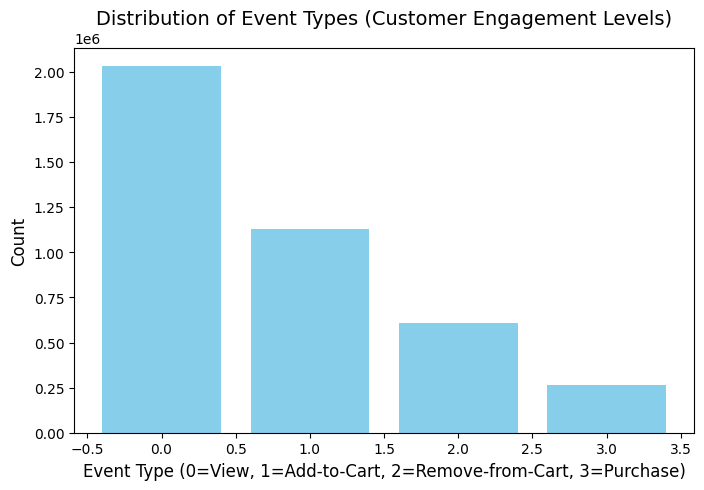

In [0]:
# Count occurrences of each class
event_counts = cosmetic_df.groupBy("event_type_index").count().toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(event_counts["event_type_index"], event_counts["count"], color="skyblue")
plt.title("Distribution of Event Types (Customer Engagement Levels)", fontsize=14)
plt.xlabel("Event Type (0=View, 1=Add-to-Cart, 2=Remove-from-Cart, 3=Purchase)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

## Predictor Variables (X): Structured Features

In [0]:
from pyspark.sql.functions import datediff, current_date
from pyspark.sql.functions import min, max
from pyspark.sql.functions import countDistinct

In [0]:
#Recency: Days since the last interaction

cosmetic_df = cosmetic_df.withColumn("recency", datediff(current_date(), col("event_time")))


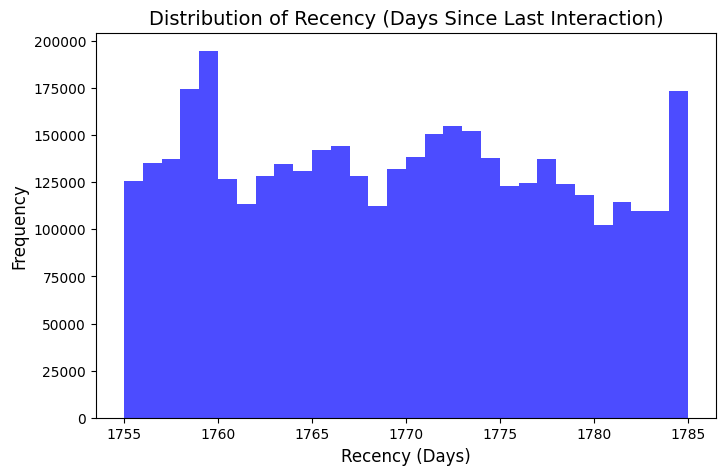

In [0]:
# Plot Recency Distribution
recency_data = cosmetic_df.select("recency").dropna().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 5))
plt.hist(recency_data, bins=30, alpha=0.7, color="blue")
plt.title("Distribution of Recency (Days Since Last Interaction)", fontsize=14)
plt.xlabel("Recency (Days)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [0]:
# Frequency: Total interactions per user session

frequency_df = cosmetic_df.groupBy("user_session").count().withColumnRenamed("count", "frequency")
cosmetic_df = cosmetic_df.join(frequency_df, on="user_session", how="left")

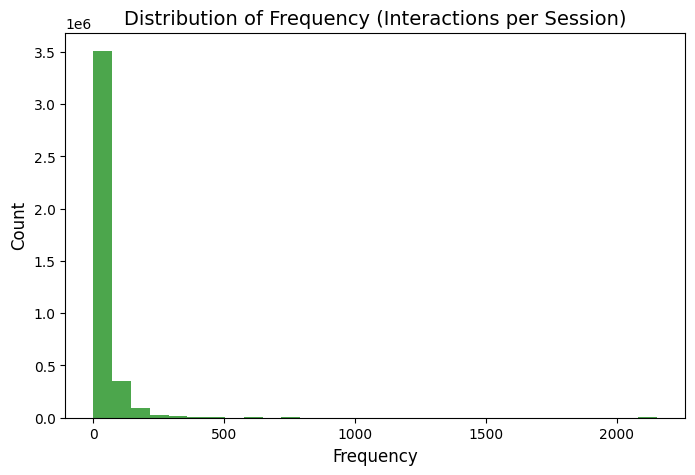

In [0]:
# Plot Frequency Distribution
frequency_data = cosmetic_df.select("frequency").dropna().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 5))
plt.hist(frequency_data, bins=30, alpha=0.7, color="green")
plt.title("Distribution of Frequency (Interactions per Session)", fontsize=14)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [0]:
# Product Popularity: Number of purchases per product

product_popularity = cosmetic_df.filter(col("event_type") == "purchase").groupBy("cosmeticProductId").count().withColumnRenamed("count", "popularity")
cosmetic_df = cosmetic_df.join(product_popularity, on="cosmeticProductId", how="left")


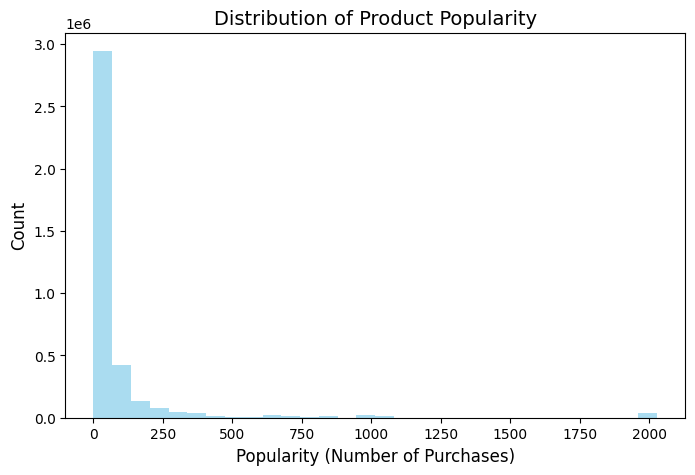

In [0]:
# Plot Product Popularity
product_popularity_data = cosmetic_df.select("popularity").dropna().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 5))
plt.hist(product_popularity_data, bins=30, alpha=0.7, color="skyblue")
plt.title("Distribution of Product Popularity", fontsize=14)
plt.xlabel("Popularity (Number of Purchases)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [0]:
# Session Duration: Time spent per session

session_duration = cosmetic_df.groupBy("user_session").agg((max("event_time") - min("event_time")).alias("duration"))
cosmetic_df = cosmetic_df.join(session_duration, on="user_session", how="left")


In [0]:
#Session Diversity: Number of unique product categories viewed in a session

session_diversity = cosmetic_df.groupBy("user_session").agg(countDistinct("category_code").alias("session_diversity"))
cosmetic_df = cosmetic_df.join(session_diversity, on="user_session", how="left")

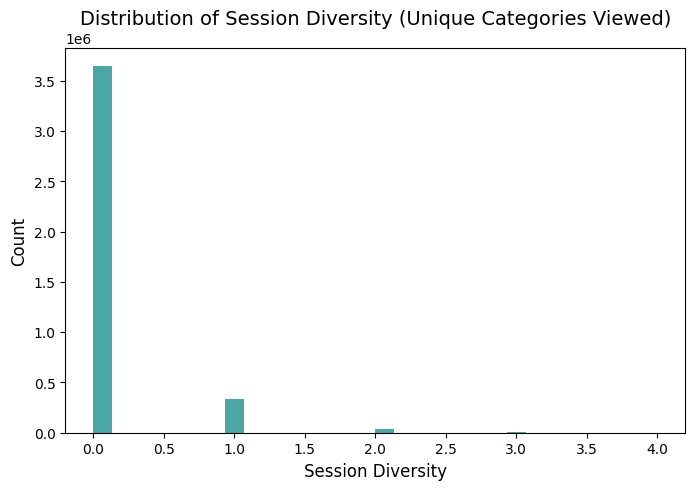

In [0]:
# Plot Session Diversity
session_diversity_data = cosmetic_df.select("session_diversity").dropna().rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 5))
plt.hist(session_diversity_data, bins=30, alpha=0.7, color="teal")
plt.title("Distribution of Session Diversity (Unique Categories Viewed)", fontsize=14)
plt.xlabel("Session Diversity", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [0]:
# Save it back to Delta tables
cosmetic_df = cosmetic_df.drop("duration") #Databricks doens't support Duration type 
cosmetic_df.write.format("delta").mode("overwrite").option("mergeSchema", "true").save(cosmetic_delta_path)
cosmetic_df = spark.read.format("delta").load(cosmetic_delta_path)